# Testing Snowplow Algorithm

In [1]:
import os
# switch directories for import
os.chdir('c:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton')

import initialize
import dual_graphs
import pandas as pd
import construction
from shortest_paths import ShortestPaths
from crossover import apply_crossover
from genetic import run_genetic
from solution import Solution
from costs import routes_cost
from params import *
import plotting
import local_search
%load_ext autoreload
%autoreload 2

Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

In [2]:
toyEdgeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\edges.csv"
toyNodeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\nodes.csv"

In [3]:
instance = "smalltoy"

match instance:
    case "smallstreets":
        G = initialize.create_small_streets()
    case "fullstreets":
        G = initialize.create_full_streets()
    case "smalltoy":
        G = initialize.create_small_toy(toyEdgeFile, toyNodeFile)
    case _:
        print("Invalid instance name")
        
approach = "genetic"

if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



In [4]:
print(G_DUAL)

MultiDiGraph with 15 nodes and 50 edges


In [5]:
sp = ShortestPaths(G_DUAL, False, True)

In [6]:
construction.process_node(G, 0, 1)

([(1,
   2,
   0,
   {'distance': 1,
    'priority': 1,
    'travel_time': 2,
    'passes_rem': 1,
    'salt_per': 1,
    'deadheading_passes': 0,
    'serviced': False}),
  (1,
   2,
   1,
   {'distance': 1,
    'priority': 3,
    'travel_time': 1,
    'passes_rem': 2,
    'salt_per': 1,
    'deadheading_passes': 0,
    'serviced': False}),
  (1,
   4,
   0,
   {'distance': 2,
    'priority': 2,
    'travel_time': 2,
    'passes_rem': 1,
    'salt_per': 1,
    'deadheading_passes': 0,
    'serviced': False})],
 3,
 4)

In [7]:
r, rreq = construction.route_generation(G, sp)


In [8]:
for route in r:
    for routestep in route:
        print(routestep)
    print("***")


0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100. Prev: None. Next: (2, 3, 0)
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 99. Prev: (0, 2, 0). Next: (3, 2, 0)
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 98. Prev: (2, 3, 0). Next: (2, 3, 1)
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 97. Prev: (3, 2, 0). Next: (3, 4, 0)
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 96. Prev: (2, 3, 1). Next: (4, 1, 0)
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 95. Prev: (3, 4, 0). Next: (1, 2, 1)
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 94. Prev: (4, 1, 0). Next: (2, 1, 1)
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 93. Prev: (1, 2, 1). Next: (1, 2, 0)
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 92. Prev: (2, 1, 1). Next: (2, 1, 0)
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 91. Prev: (1, 2, 0). Next: (1, 4, 0)
1 --> 4. (0) Deadhead: 

In [9]:
for route in rreq:
    for routestep in route:
        print(routestep)

0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100. Prev: None. Next: (2, 3, 0)
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 99. Prev: (0, 2, 0). Next: (3, 2, 0)
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 98. Prev: (2, 3, 0). Next: (2, 3, 1)
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 97. Prev: (3, 2, 0). Next: (3, 4, 0)
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 96. Prev: (2, 3, 1). Next: (4, 1, 0)
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 95. Prev: (3, 4, 0). Next: (1, 2, 1)
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 94. Prev: (4, 1, 0). Next: (2, 1, 1)
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 93. Prev: (1, 2, 1). Next: (1, 2, 0)
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 92. Prev: (2, 1, 1). Next: (2, 1, 0)
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 91. Prev: (1, 2, 0). Next: (1, 4, 0)
1 --> 4. (0) Deadhead: 

Test Local Search

In [10]:
required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq), 0)

routes_cost(G, sp, S_first.routes)

164.0

In [17]:
S_new = local_search.local_improve(S_first, G, sp, required_edges, K, threshold=1)

In [ ]:
routes_cost(G, sp, S_new.routes)

In [ ]:
for route in S_first.routes:
    for routestep in route:
        print(routestep)
    print("***")

0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100. Prev: None. Next: (2, 1, 1)
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 99. Prev: (0, 2, 0). Next: (1, 2, 0)
1 --> 2. (0) Deadhead: False. Had options: True. Salt value: 98. Prev: (2, 1, 1). Next: (2, 0, 0)
2 --> 0. (0) Deadhead: False. Had options: True. Salt value: 97. Prev: (1, 2, 0). Next: (2, 3, 1)
***
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 100. Prev: (2, 0, 0). Next: (3, 4, 0)
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 99. Prev: (2, 3, 1). Next: (4, 3, 0)
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 98. Prev: (3, 4, 0). Next: (3, 2, 1)
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 97. Prev: (4, 3, 0). Next: (2, 1, 0)
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 96. Prev: (3, 2, 1). Next: (1, 2, 1)
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 95. Prev: (2, 1, 0). Next: (2, 3, 0)
2 --> 3. (0) Deadh

In [ ]:
for route in S_new.routes:
    for routestep in route:
        print(routestep)
    print("***")

0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100. Prev: (0, 0, 0). Next: (2, 3, 0)
2 --> 3. (0) Deadhead: False. Had options: True. Salt value: 94. Prev: (0, 2, 0). Next: (3, 2, 0)
3 --> 2. (0) Deadhead: False. Had options: True. Salt value: 93. Prev: (2, 3, 0). Next: (2, 0, 0)
2 --> 0. (0) Deadhead: False. Had options: True. Salt value: 97. Prev: (3, 2, 0). Next: (0, 0, 0)
***
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 100. Prev: (0, 0, 0). Next: (3, 4, 0)
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 99. Prev: (2, 3, 1). Next: (4, 3, 0)
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 98. Prev: (3, 4, 0). Next: (3, 2, 1)
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 97. Prev: (4, 3, 0). Next: (2, 1, 1)
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 99. Prev: (3, 2, 1). Next: (1, 2, 1)
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 95. Prev: (2, 1, 1). Next: (2, 1, 0)
2 --> 1. (0) 

initial generation 0
0 --> 2. (0) Deadhead: False. Had options: False. Salt value: 100. Prev: (0, 0, 0). Next: (2, 1, 1)
2 --> 1. (1) Deadhead: False. Had options: True. Salt value: 99. Prev: (0, 2, 0). Next: (1, 2, 1)
1 --> 2. (1) Deadhead: False. Had options: True. Salt value: 98. Prev: (2, 1, 1). Next: (2, 3, 1)
2 --> 3. (1) Deadhead: False. Had options: True. Salt value: 97. Prev: (1, 2, 1). Next: (3, 2, 1)
3 --> 2. (1) Deadhead: False. Had options: True. Salt value: 94. Prev: (2, 3, 1). Next: (0, 0, 0)
**************
1 --> 4. (0) Deadhead: False. Had options: True. Salt value: 99. Prev: (0, 0, 0). Next: (4, 1, 0)
4 --> 1. (0) Deadhead: False. Had options: True. Salt value: 98. Prev: (1, 4, 0). Next: (4, 3, 0)
4 --> 3. (0) Deadhead: False. Had options: True. Salt value: 95. Prev: (4, 1, 0). Next: (2, 1, 0)
2 --> 1. (0) Deadhead: False. Had options: True. Salt value: 100. Prev: (4, 3, 0). Next: (3, 4, 0)
3 --> 4. (0) Deadhead: False. Had options: True. Salt value: 96. Prev: (2, 1, 0

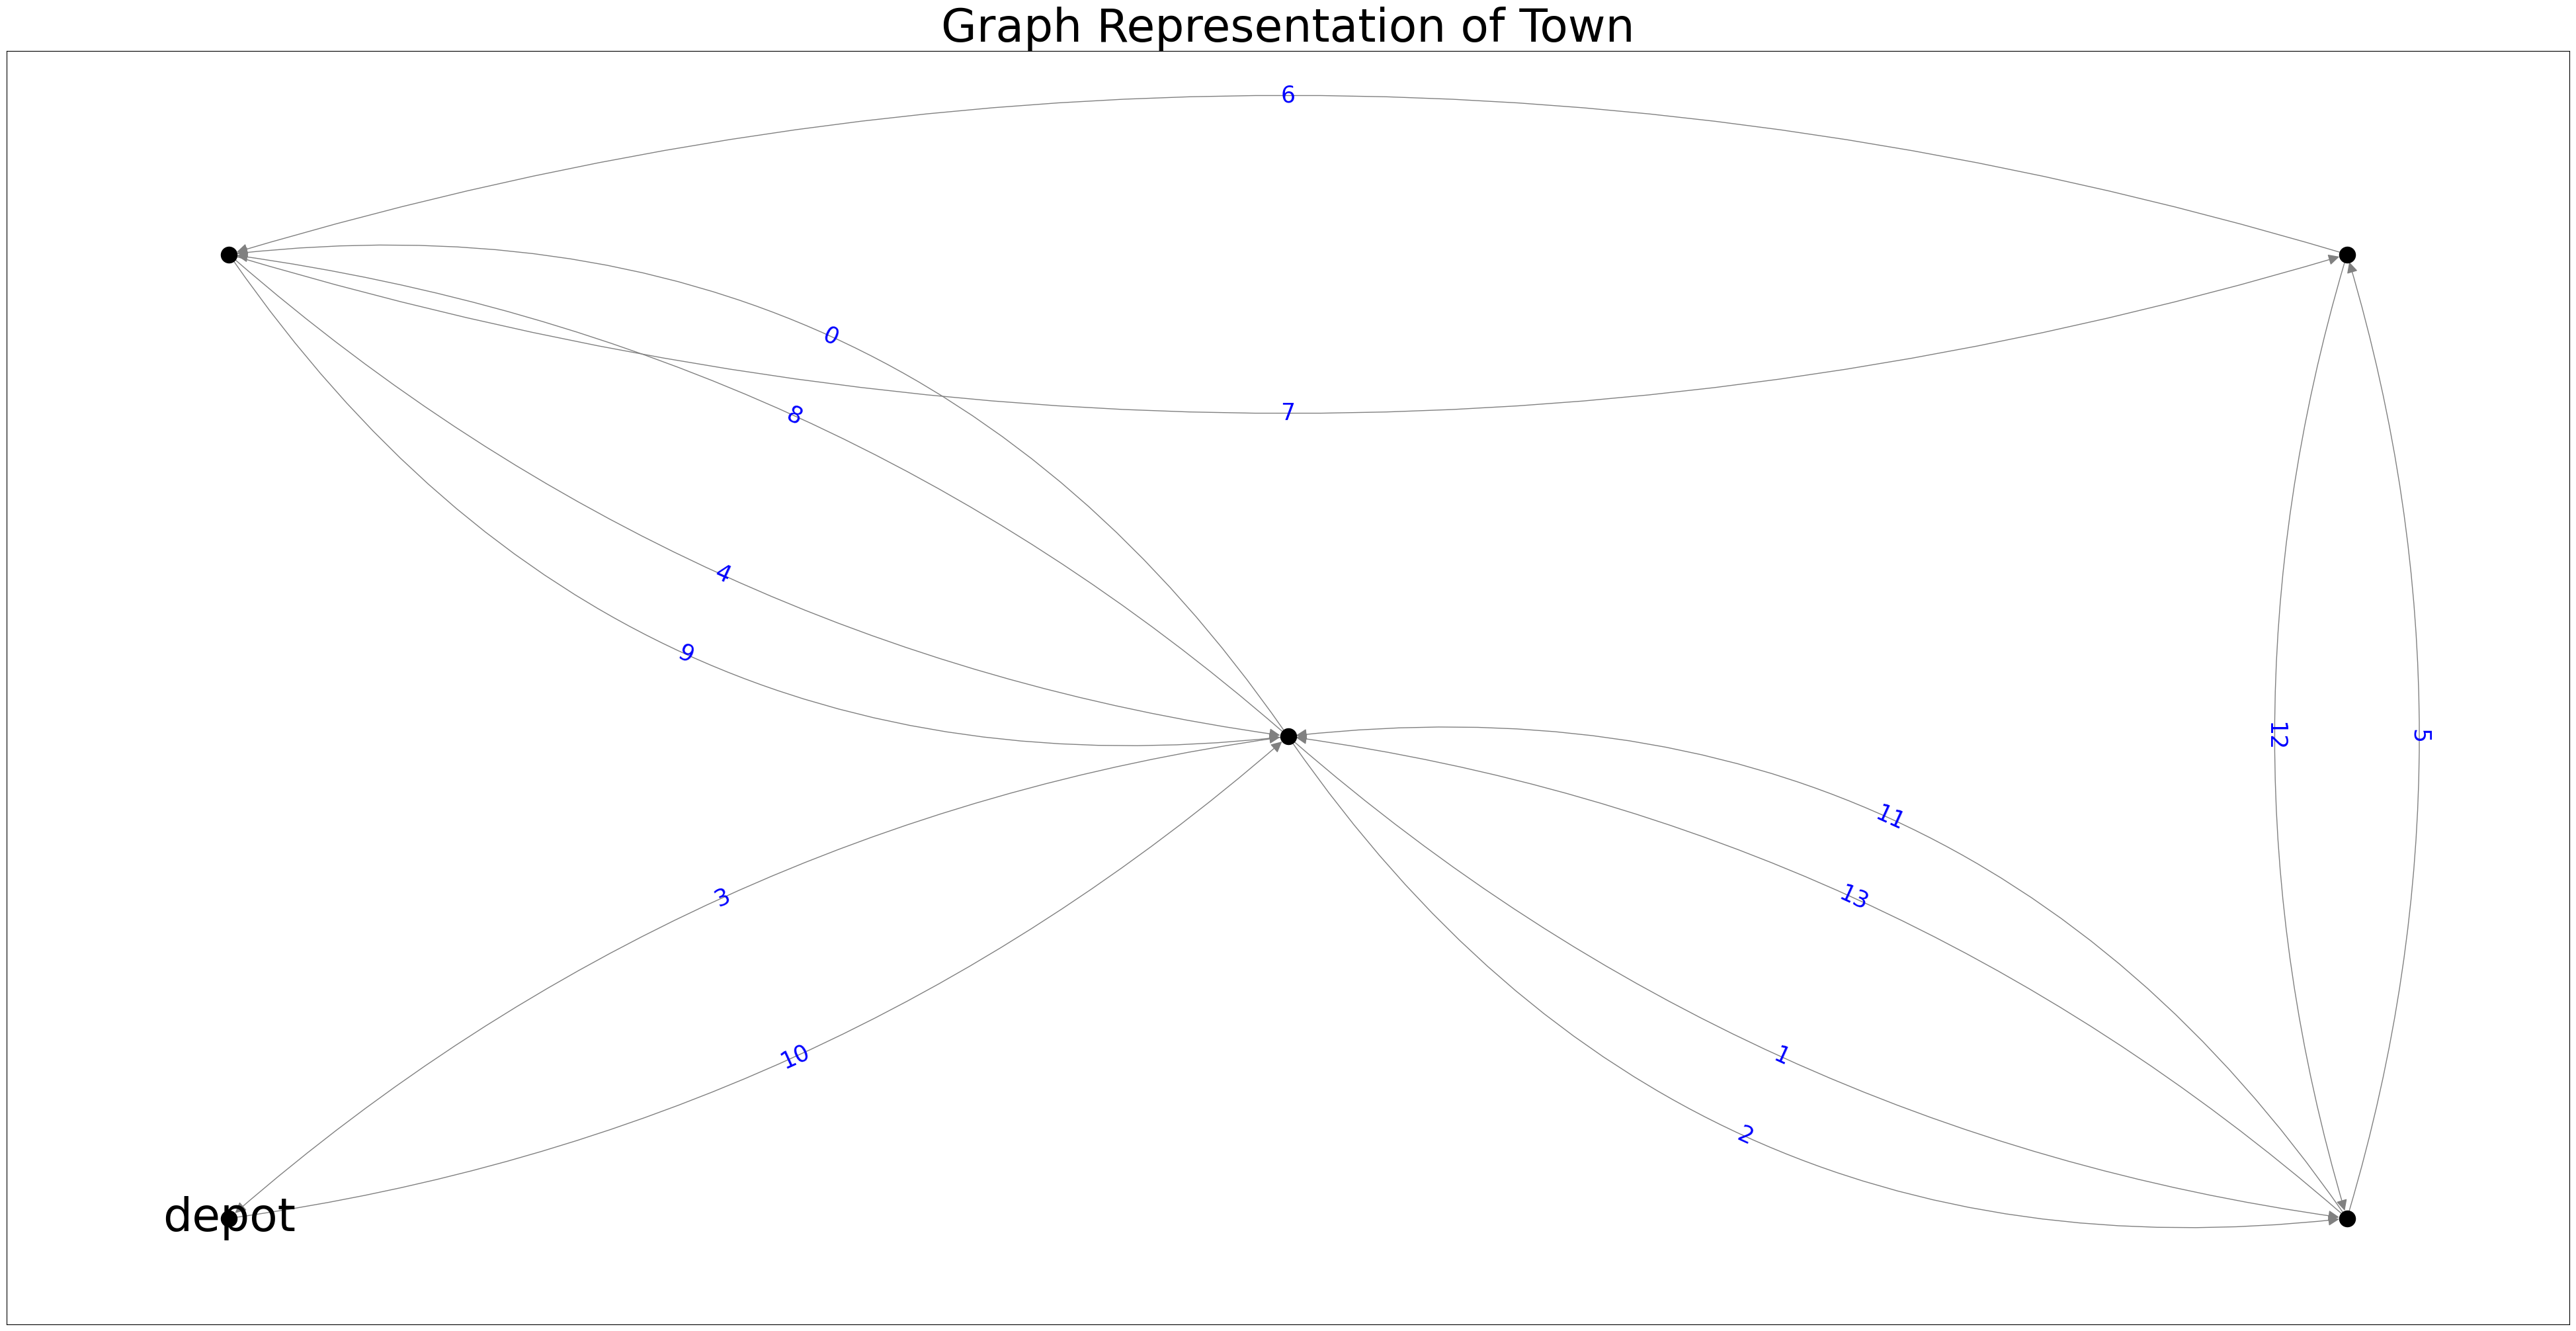

DONE
Routes cost 122.0


In [ ]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")


# 5. Plot final routes
G_graph = plotting.add_order_attribute(G, sol.routes)
plotting.draw_labeled_multigraph(G_graph, 'order', size=(50,25))

print("DONE")
print("Routes cost", sol.cost)